
--- Model Accuracy Metrics ---


,RMSE,R²,AIC,BIC,Adj-AIC,Adj-BIC
Logistic,17.9346,0.9829,933.5277,939.6905,933.6036,939.7284
Gompertz,3.1618,0.9995,376.6643,385.9085,376.8171,385.9849
Richards,0.9964,0.9999,8.8395,24.2465,9.2266,24.4400
LTVLMS,1.7194,0.9998,182.5153,194.8409,182.7717,194.9692



--- Parameter Estimates ---


,K,r,r₀,r₁,t₀,α,ν
Logistic,427.4336,0.2247,NaN,NaN,NaN,NaN,NaN
Gompertz,434.5892,0.0965,NaN,NaN,22.0379,NaN,NaN
Richards,433.6278,0.1112,NaN,NaN,22.3091,0.432,0.3566
LTVLMS,433.9479,NaN,0.5534,-0.0,NaN,NaN,0.1897


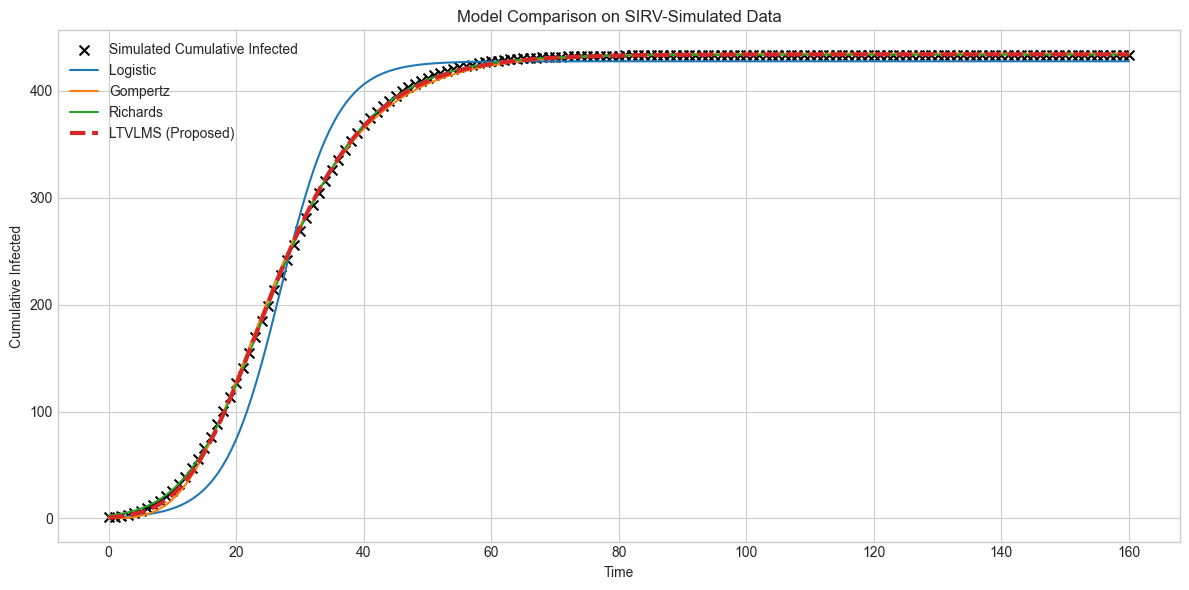

In [9]:
# --- Imports and Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from pyDOE import lhs
import warnings, os

# Setup
np.random.seed(42)
warnings.filterwarnings("ignore")
os.makedirs("plots", exist_ok=True)

# --- Load SIRV Simulated Data ---
df = pd.read_csv("C:/Users/Red1/Documents/sirv_simulation.csv")  # Update path if needed
t = df["time"].values
prevalence = df["cumulative_infected"].values

# --- Model Definitions ---
def logistic_model(t, K, r):
    y0 = prevalence[0]
    return K / (1 + ((K - y0) / y0) * np.exp(-r * t))

def gompertz_model(t, K, r, t0):
    return K * np.exp(-np.exp(-r * (t - t0)))

def richards_model(t, K, r, t0, alpha, nu):
    return K / ((1 + alpha * np.exp(-r * (t - t0)))**(1 / nu))

def ltvlms_model(t, K, r0, r1, nu):
    y0 = prevalence[0]
    expo_term = -nu * (r0 * t + 0.5 * r1 * t**2)
    inner = 1 + ((K**nu - y0**nu) / y0**nu) * np.exp(expo_term)
    return K / (inner**(1 / nu))

# --- Metric Function ---
def compute_metrics(y_true, y_pred, k):
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)
    adj_aic = aic + (2 * k * (k + 1)) / (n - k - 1)
    adj_bic = bic + (k * (k + 1)) / (n - k - 1)
    return rmse, r2, aic, bic, adj_aic, adj_bic

# --- Latin Hypercube Sampling ---
def latin_hypercube_init(bounds, n_samples=50):
    dim = len(bounds)
    lhs_samples = lhs(dim, samples=n_samples)
    return np.array([
        bounds[i][0] + (bounds[i][1] - bounds[i][0]) * lhs_samples[:, i]
        for i in range(dim)
    ]).T

# --- Multi-start Fit ---
def multi_start_fit(model_func, t, y, bounds, n_starts=50):
    best_score = np.inf
    best_params = None
    for guess in latin_hypercube_init(bounds, n_starts):
        try:
            params, _ = curve_fit(model_func, t, y, p0=guess, bounds=np.array(bounds).T, maxfev=100000)
            score = mean_squared_error(y, model_func(t, *params))
            if score < best_score:
                best_score = score
                best_params = params
        except:
            continue
    return best_params

# --- Bounds Setup ---
y0 = prevalence[0]
K_bounds = [0.5 * max(prevalence), 2 * max(prevalence)]
r_bounds = [0.0001, 1.0]
t0_bounds = [0, t[-1]]
alpha_bounds = [0.001, 10]
nu_bounds = [0.01, 10]
r1_bounds = [-1, 0]

bounds_logistic = [K_bounds, r_bounds]
bounds_gompertz = [K_bounds, r_bounds, t0_bounds]
bounds_richards = [K_bounds, r_bounds, t0_bounds, alpha_bounds, nu_bounds]
bounds_ltvlms = [K_bounds, r_bounds, r1_bounds, nu_bounds]

# --- Fit Models ---
params_logistic = multi_start_fit(logistic_model, t, prevalence, bounds_logistic)
params_gompertz = multi_start_fit(gompertz_model, t, prevalence, bounds_gompertz)
params_richards = multi_start_fit(richards_model, t, prevalence, bounds_richards)
params_ltvlms = multi_start_fit(ltvlms_model, t, prevalence, bounds_ltvlms)

# --- Evaluate Metrics ---
preds = {
    "Logistic": logistic_model(t, *params_logistic),
    "Gompertz": gompertz_model(t, *params_gompertz),
    "Richards": richards_model(t, *params_richards),
    "LTVLMS": ltvlms_model(t, *params_ltvlms)
}

results = {}
for name, y_hat in preds.items():
    params = eval(f"params_{name.lower()}")
    results[name] = compute_metrics(prevalence, y_hat, len(params))

metrics_df = pd.DataFrame(results, index=["RMSE", "R²", "AIC", "BIC", "Adj-AIC", "Adj-BIC"]).T

param_df = pd.DataFrame({
    "Logistic": pd.Series(params_logistic, index=["K", "r"]),
    "Gompertz": pd.Series(params_gompertz, index=["K", "r", "t₀"]),
    "Richards": pd.Series(params_richards, index=["K", "r", "t₀", "α", "ν"]),
    "LTVLMS": pd.Series(params_ltvlms, index=["K", "r₀", "r₁", "ν"]),
}).T

# --- Print Results ---
from IPython.display import display
print("\n--- Model Accuracy Metrics ---")
display(metrics_df.round(4))

print("\n--- Parameter Estimates ---")
display(param_df.round(4))

# --- Plot Results ---
t_fine = np.linspace(t[0], t[-1], 500)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))
plt.scatter(t, prevalence, label='Simulated Cumulative Infected', color='black', s=50, marker='x')
plt.plot(t_fine, logistic_model(t_fine, *params_logistic), label='Logistic')
plt.plot(t_fine, gompertz_model(t_fine, *params_gompertz), label='Gompertz')
plt.plot(t_fine, richards_model(t_fine, *params_richards), label='Richards')
plt.plot(t_fine, ltvlms_model(t_fine, *params_ltvlms), label='LTVLMS (Proposed)', linestyle='--', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Cumulative Infected')
plt.title('Model Comparison on SIRV-Simulated Data')
plt.legend()
plt.tight_layout()
plt.savefig("plots/sirv_model_comparison.eps", format='eps')
plt.savefig("plots/sirv_model_comparison.pdf")
plt.show()
